In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)

2023-02-28 18:48:42.277318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 18:48:43.514635: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-02-28 18:48:43.514762: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LI

In [2]:
# full_img_path = '/mnt/d/Datasets/CBIS_DDSM/full/'
roi_img_path = '/mnt/d/CBIS-DDSM/new_ROI/augmented/'
img_height = 300
img_width = 300
batch_size = 16
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# def global_contrast_normalization(image):
#     mean = tf.reduce_mean(image)
#     variance = tf.math.reduce_variance(image)
#     return tf.divide(tf.subtract(image, mean), tf.sqrt(variance + 1e-6))
# 
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=global_contrast_normalization)
# 
# train = datagen.flow_from_directory(
        # roi_img_path+'train/',
        # target_size=(300, 300),
        # batch_size=batch_size,
        # class_mode='categorical')
# val = datagen.flow_from_directory(
        # roi_img_path+'val/',
        # target_size=(300, 300),
        # batch_size=batch_size,
        # class_mode='categorical')
# test = datagen.flow_from_directory(
        # roi_img_path+'test/',
        # target_size=(300, 300),
        # batch_size=batch_size,
        # class_mode='categorical')

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
train = train_ds.prefetch(AUTOTUNE)
val = val_ds.prefetch(AUTOTUNE)

Found 3216 files belonging to 2 classes.
Found 220 files belonging to 2 classes.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
test = test_ds.prefetch(AUTOTUNE)

Found 322 files belonging to 2 classes.


In [6]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f' Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')

# Inception V3

In [7]:
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=False,
    Earlystop=False,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = False,
    regulariser=False,
    train_log='/home/jj/FYP/log/InceptionV3_CBIS_DDSM/InceptionV3_CBIS_DDSM_dense.csv',
    load_weights = False,
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/Dense/best_model',
    learning_rate=5e-5,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

2023-02-28 18:49:04.946888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-28 18:49:08.312707: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-28 18:49:08.986432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-28 18:49:08.996406: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f144407b0b0 initialized for platform CUDA (this does not guarantee

201/201 [==============================] - 50s 191ms/step - loss: 0.6759 - categorical_accuracy: 0.5690 - recall_8: 0.6113 - recall_9: 0.5308 - val_loss: 0.6404 - val_categorical_accuracy: 0.6318 - val_recall_8: 0.8182 - val_recall_9: 0.4793
Epoch 2/2
201/201 [==============================] - 36s 180ms/step - loss: 0.6208 - categorical_accuracy: 0.6586 - recall_8: 0.7035 - recall_9: 0.6179 - val_loss: 0.6467 - val_categorical_accuracy: 0.6318 - val_recall_8: 0.9394 - val_recall_9: 0.3802
Epoch 3/3
201/201 [==============================] - 36s 179ms/step - loss: 0.5974 - categorical_accuracy: 0.6813 - recall_8: 0.7349 - recall_9: 0.6327 - val_loss: 0.6323 - val_categorical_accuracy: 0.6409 - val_recall_8: 0.9394 - val_recall_9: 0.3967
Epoch 4/4
201/201 [==============================] - 36s 179ms/step - loss: 0.5841 - categorical_accuracy: 0.6897 - recall_8: 0.7297 - recall_9: 0.6534 - val_loss: 0.6573 - val_categorical_accuracy: 0.6000 - val_recall_8: 0.9495 - val_recall_9: 0.3140
Ep

## Fine Tune

In [8]:
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=5,
    Earlystop=20,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log='/home/jj/FYP/log/InceptionV3_CBIS_DDSM/InceptionV3_CBIS_DDSM_Fine_Tune.csv',
    load_weights = '/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/Dense/best_model',
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

## Figures

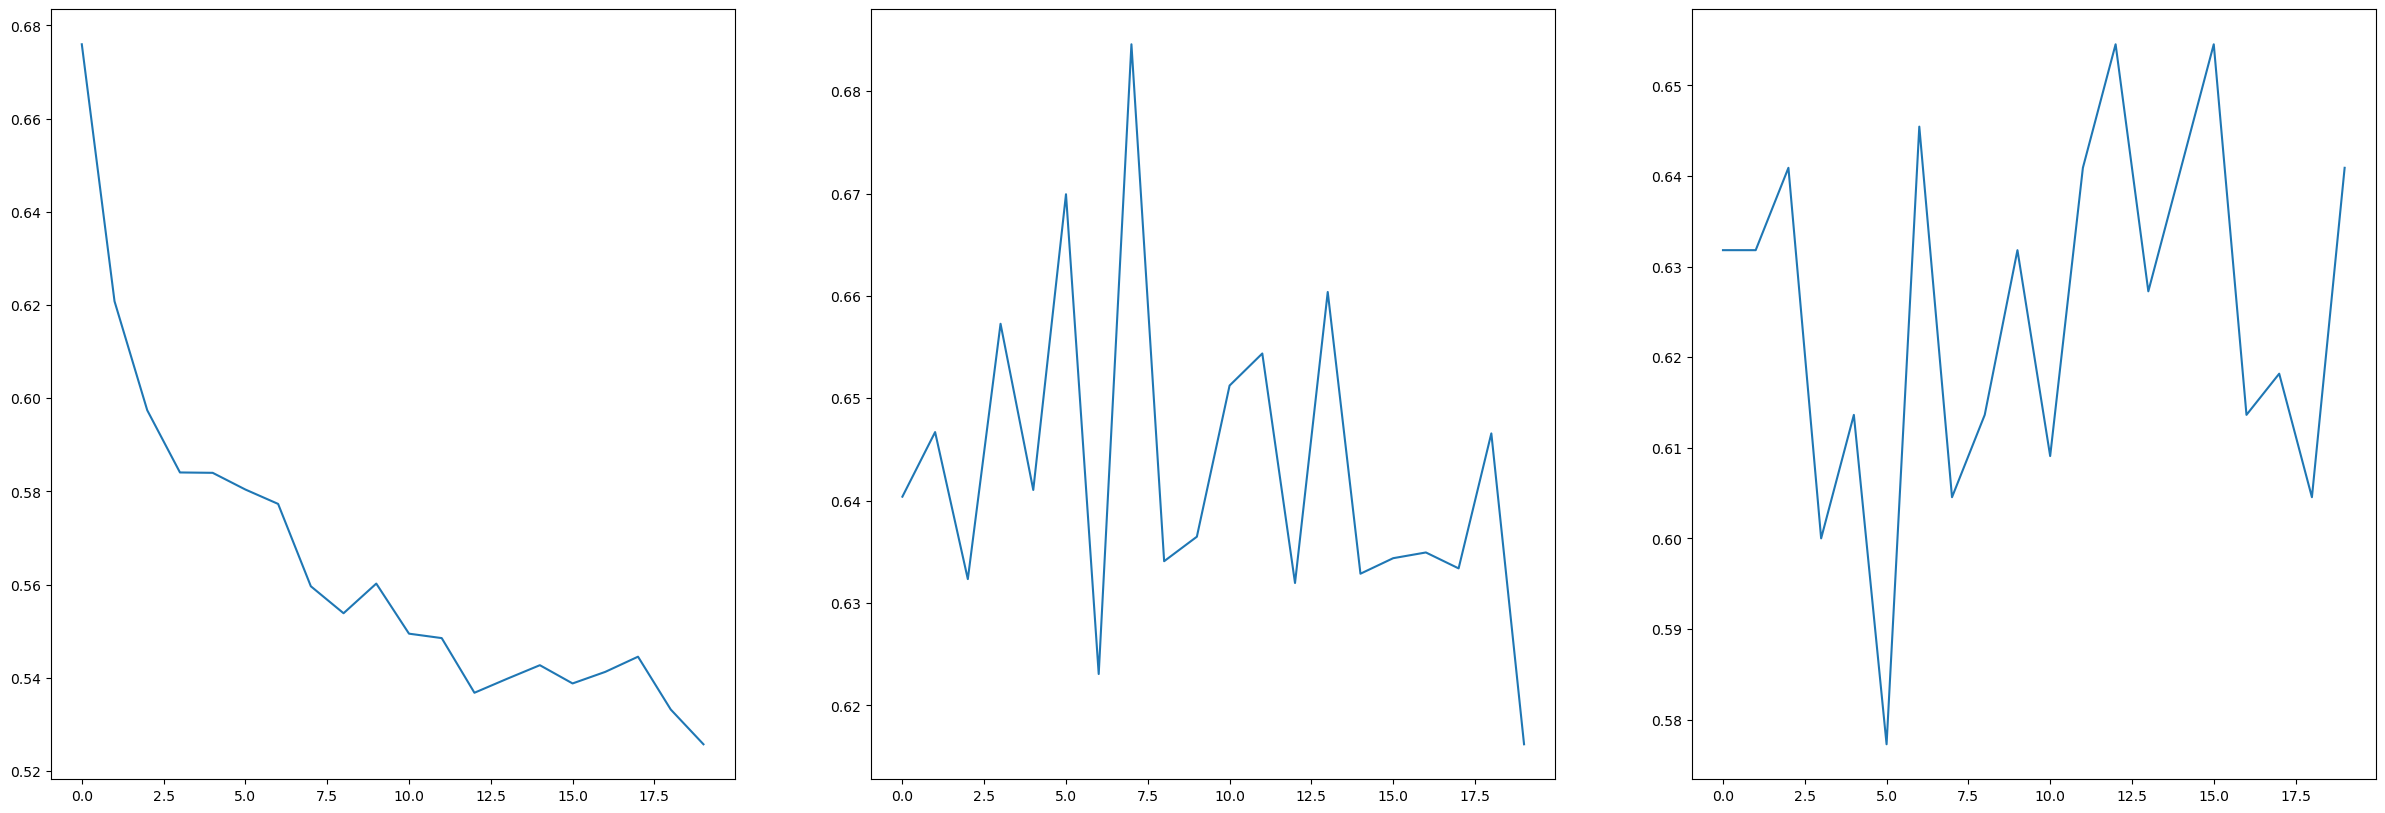

In [9]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(inception_dense_history['train_loss'])
plt.subplot(132)
plt.plot(inception_dense_history['val_loss'])
plt.subplot(133)
plt.plot(inception_dense_history['val_acc'])

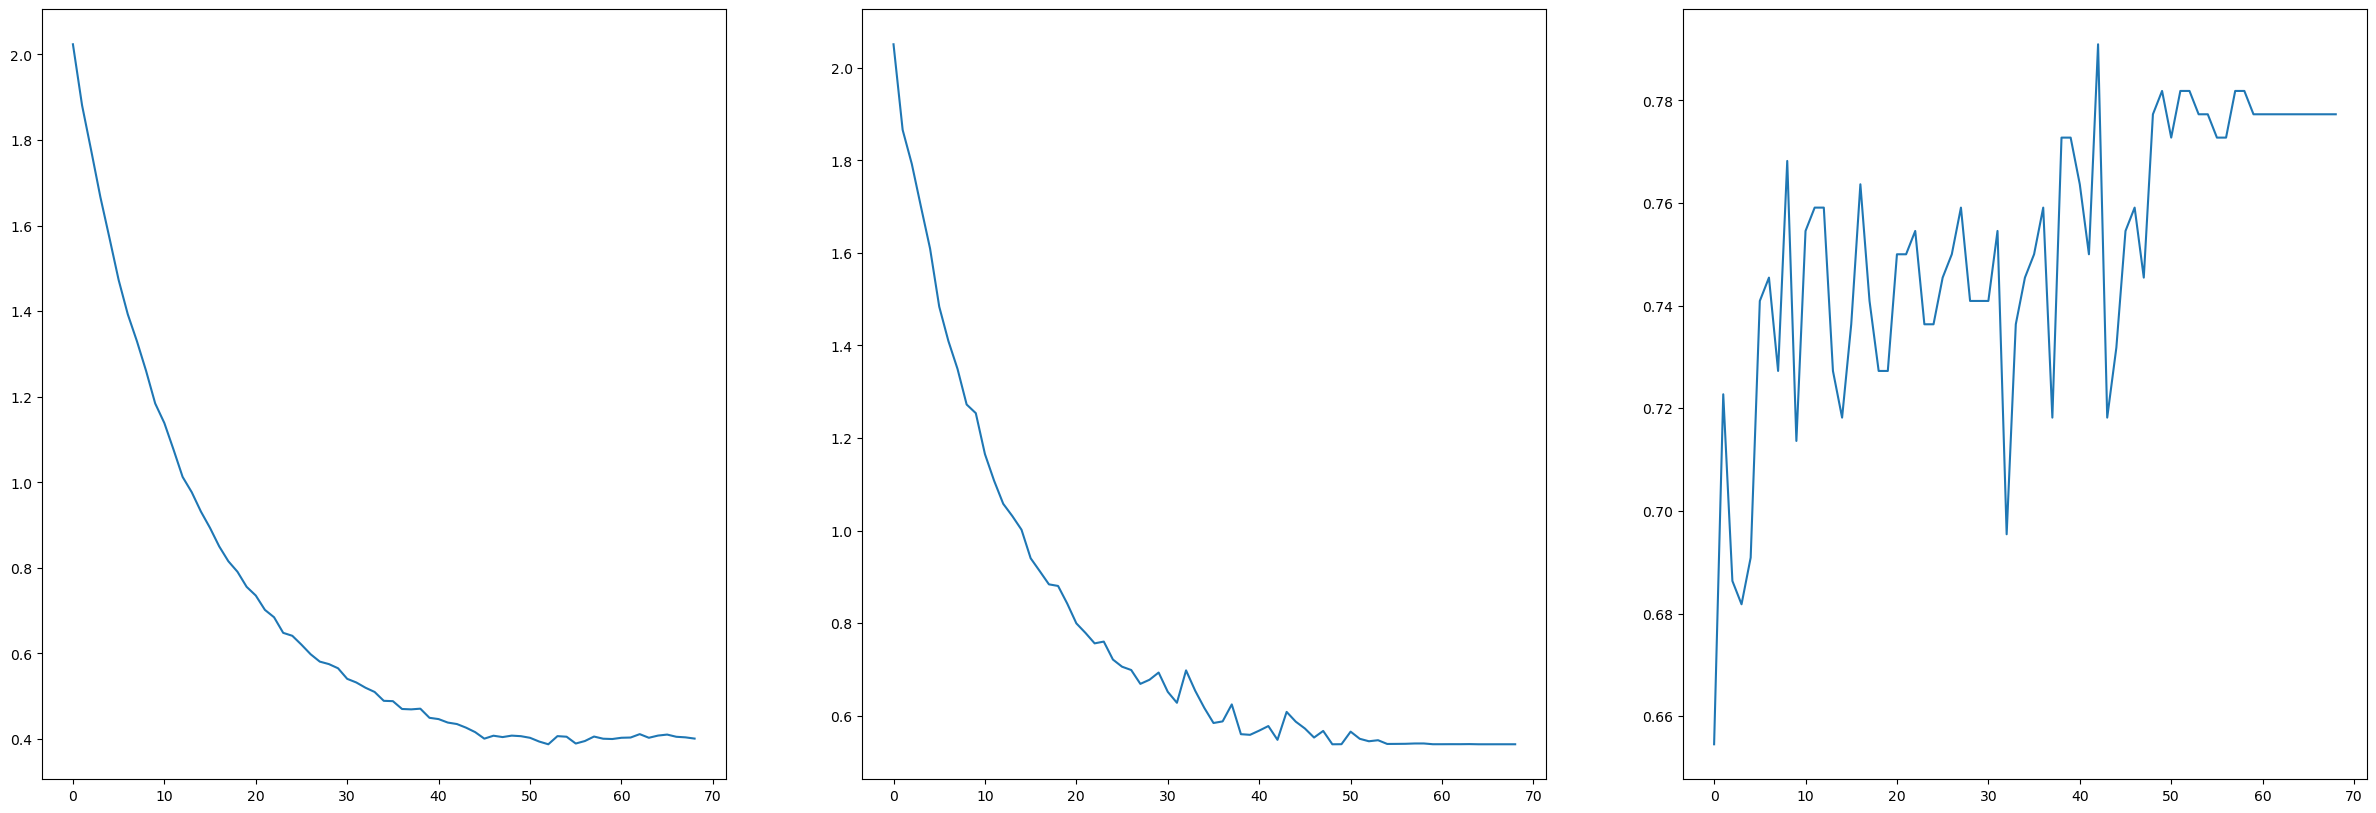

In [10]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(inception_fine_tune_history['train_loss'])
plt.subplot(132)
plt.plot(inception_fine_tune_history['val_loss'])
plt.subplot(133)
plt.plot(inception_fine_tune_history['val_acc'])


## Test

In [11]:
model.load_weights('/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

21/21 [==============================] - 11s 268ms/step - loss: 0.7194 - categorical_accuracy: 0.6739 - precision: 0.7923 - precision_1: 0.5938


Image without padding, normalisation used

21/21 [==============================] - 2s 40ms/step - loss: 0.8528 - categorical_accuracy: 0.7019 - precision_2: 0.7778 - precision_3: 0.6331


# EfficientNet V2M

## Initialising

In [12]:
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Efficientnetv2m_CBIS_DDSM/'
model, effnetv2m_dense_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = False,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 8)                 1024008   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                             

## Fine Tuning

In [13]:
model, effnetv2m_fine_tune_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1024008   
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                           

2023-02-22 02:34:36.165409: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:34:36.166066: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:34:36.178397: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:34:36.178425: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

102/102 [==============================] - ETA: 0s - loss: 1.4916 - categorical_accuracy: 0.5724 - precision_2: 0.5415 - precision_3: 0.6320

2023-02-22 02:35:01.563317: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:35:01.563354: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 Epoch 0: accuracy=0.5724, loss=1.4916, val_accuracy=0.6412, val_loss=1.4200,  - lr=0.0010000
102/102 [==============================] - 41s 301ms/step - loss: 1.4916 - categorical_accuracy: 0.5724 - precision_2: 0.5415 - precision_3: 0.6320 - val_loss: 1.4200 - val_categorical_accuracy: 0.6412 - val_precision_2: 0.6344 - val_precision_3: 0.6463
Epoch 2/2
102/102 [==============================] - 29s 279ms/step - loss: 1.4567 - categorical_accuracy: 0.5362 - precision_2: 0.5128 - precision_3: 0.5965 - val_loss: 1.3928 - val_categorical_accuracy: 0.6481 - val_precision_2: 0.6210 - val_precision_3: 0.6761
Epoch 3/3
102/102 [==============================] - 29s 278ms/step - loss: 1.4083 - categorical_accuracy: 0.5755 - precision_2: 0.5427 - precision_3: 0.6434 - val_loss: 1.3608 - val_categorical_accuracy: 0.6435 - val_precision_2: 0.6491 - val_precision_3: 0.6398
Epoch 4/4
102/102 [==============================] - 29s 278ms/step - loss: 1.3811 - categorical_accuracy: 0.5583 - precisio

## Figures

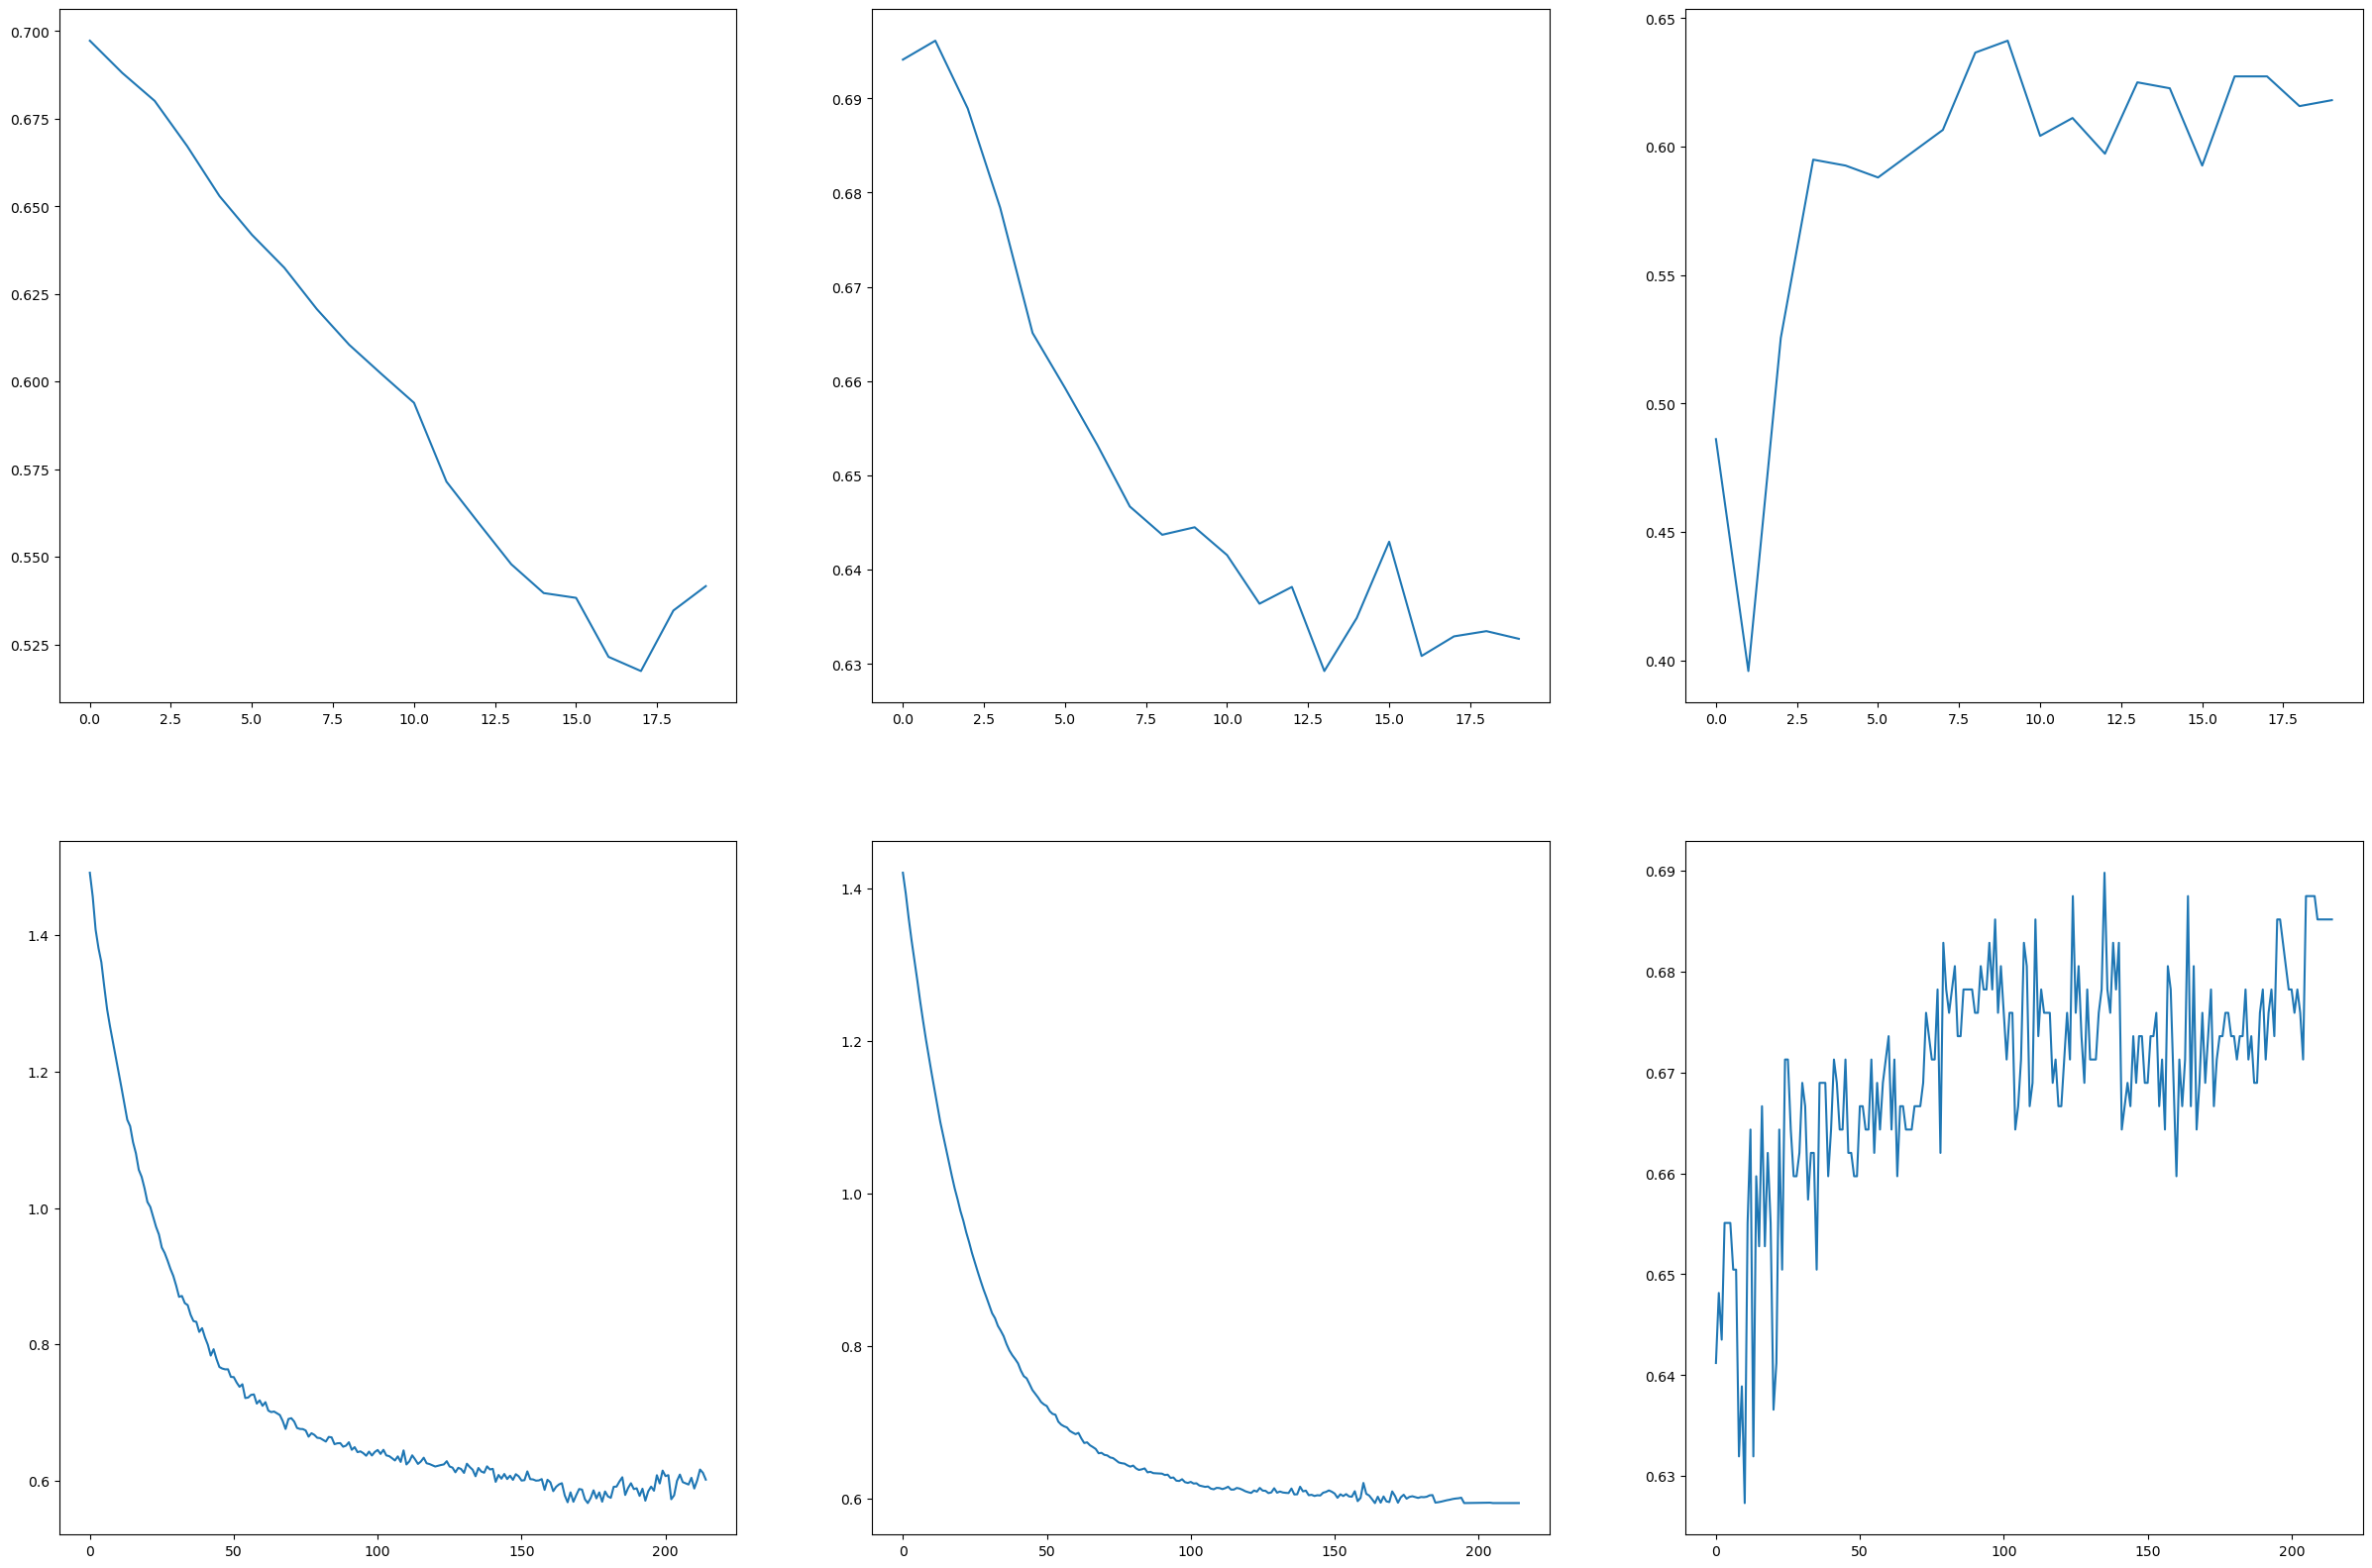

In [14]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(effnetv2m_dense_history['train_loss'])
plt.subplot(232)
plt.plot(effnetv2m_dense_history['val_loss'])
plt.subplot(233)
plt.plot(effnetv2m_dense_history['val_acc'])
plt.subplot(234)
plt.plot(effnetv2m_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(effnetv2m_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(effnetv2m_fine_tune_history['val_acc'])

## Test

In [15]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

21/21 [==============================] - 3s 133ms/step - loss: 0.6264 - categorical_accuracy: 0.6759 - precision_2: 0.7619 - precision_3: 0.6045


# Resnet50

## Initialising

In [16]:
weights = '/home/jj/FYP/Checkpoint/Resnet50_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Resnet50_CBIS_DDSM/'
model, resnet_dense_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = False,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.L2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 8)                 1638408   
                                                             

## Fine Tune

In [17]:
model, resnet_fine_tune_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=300,
    patience=30,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 22,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0   

## Figures

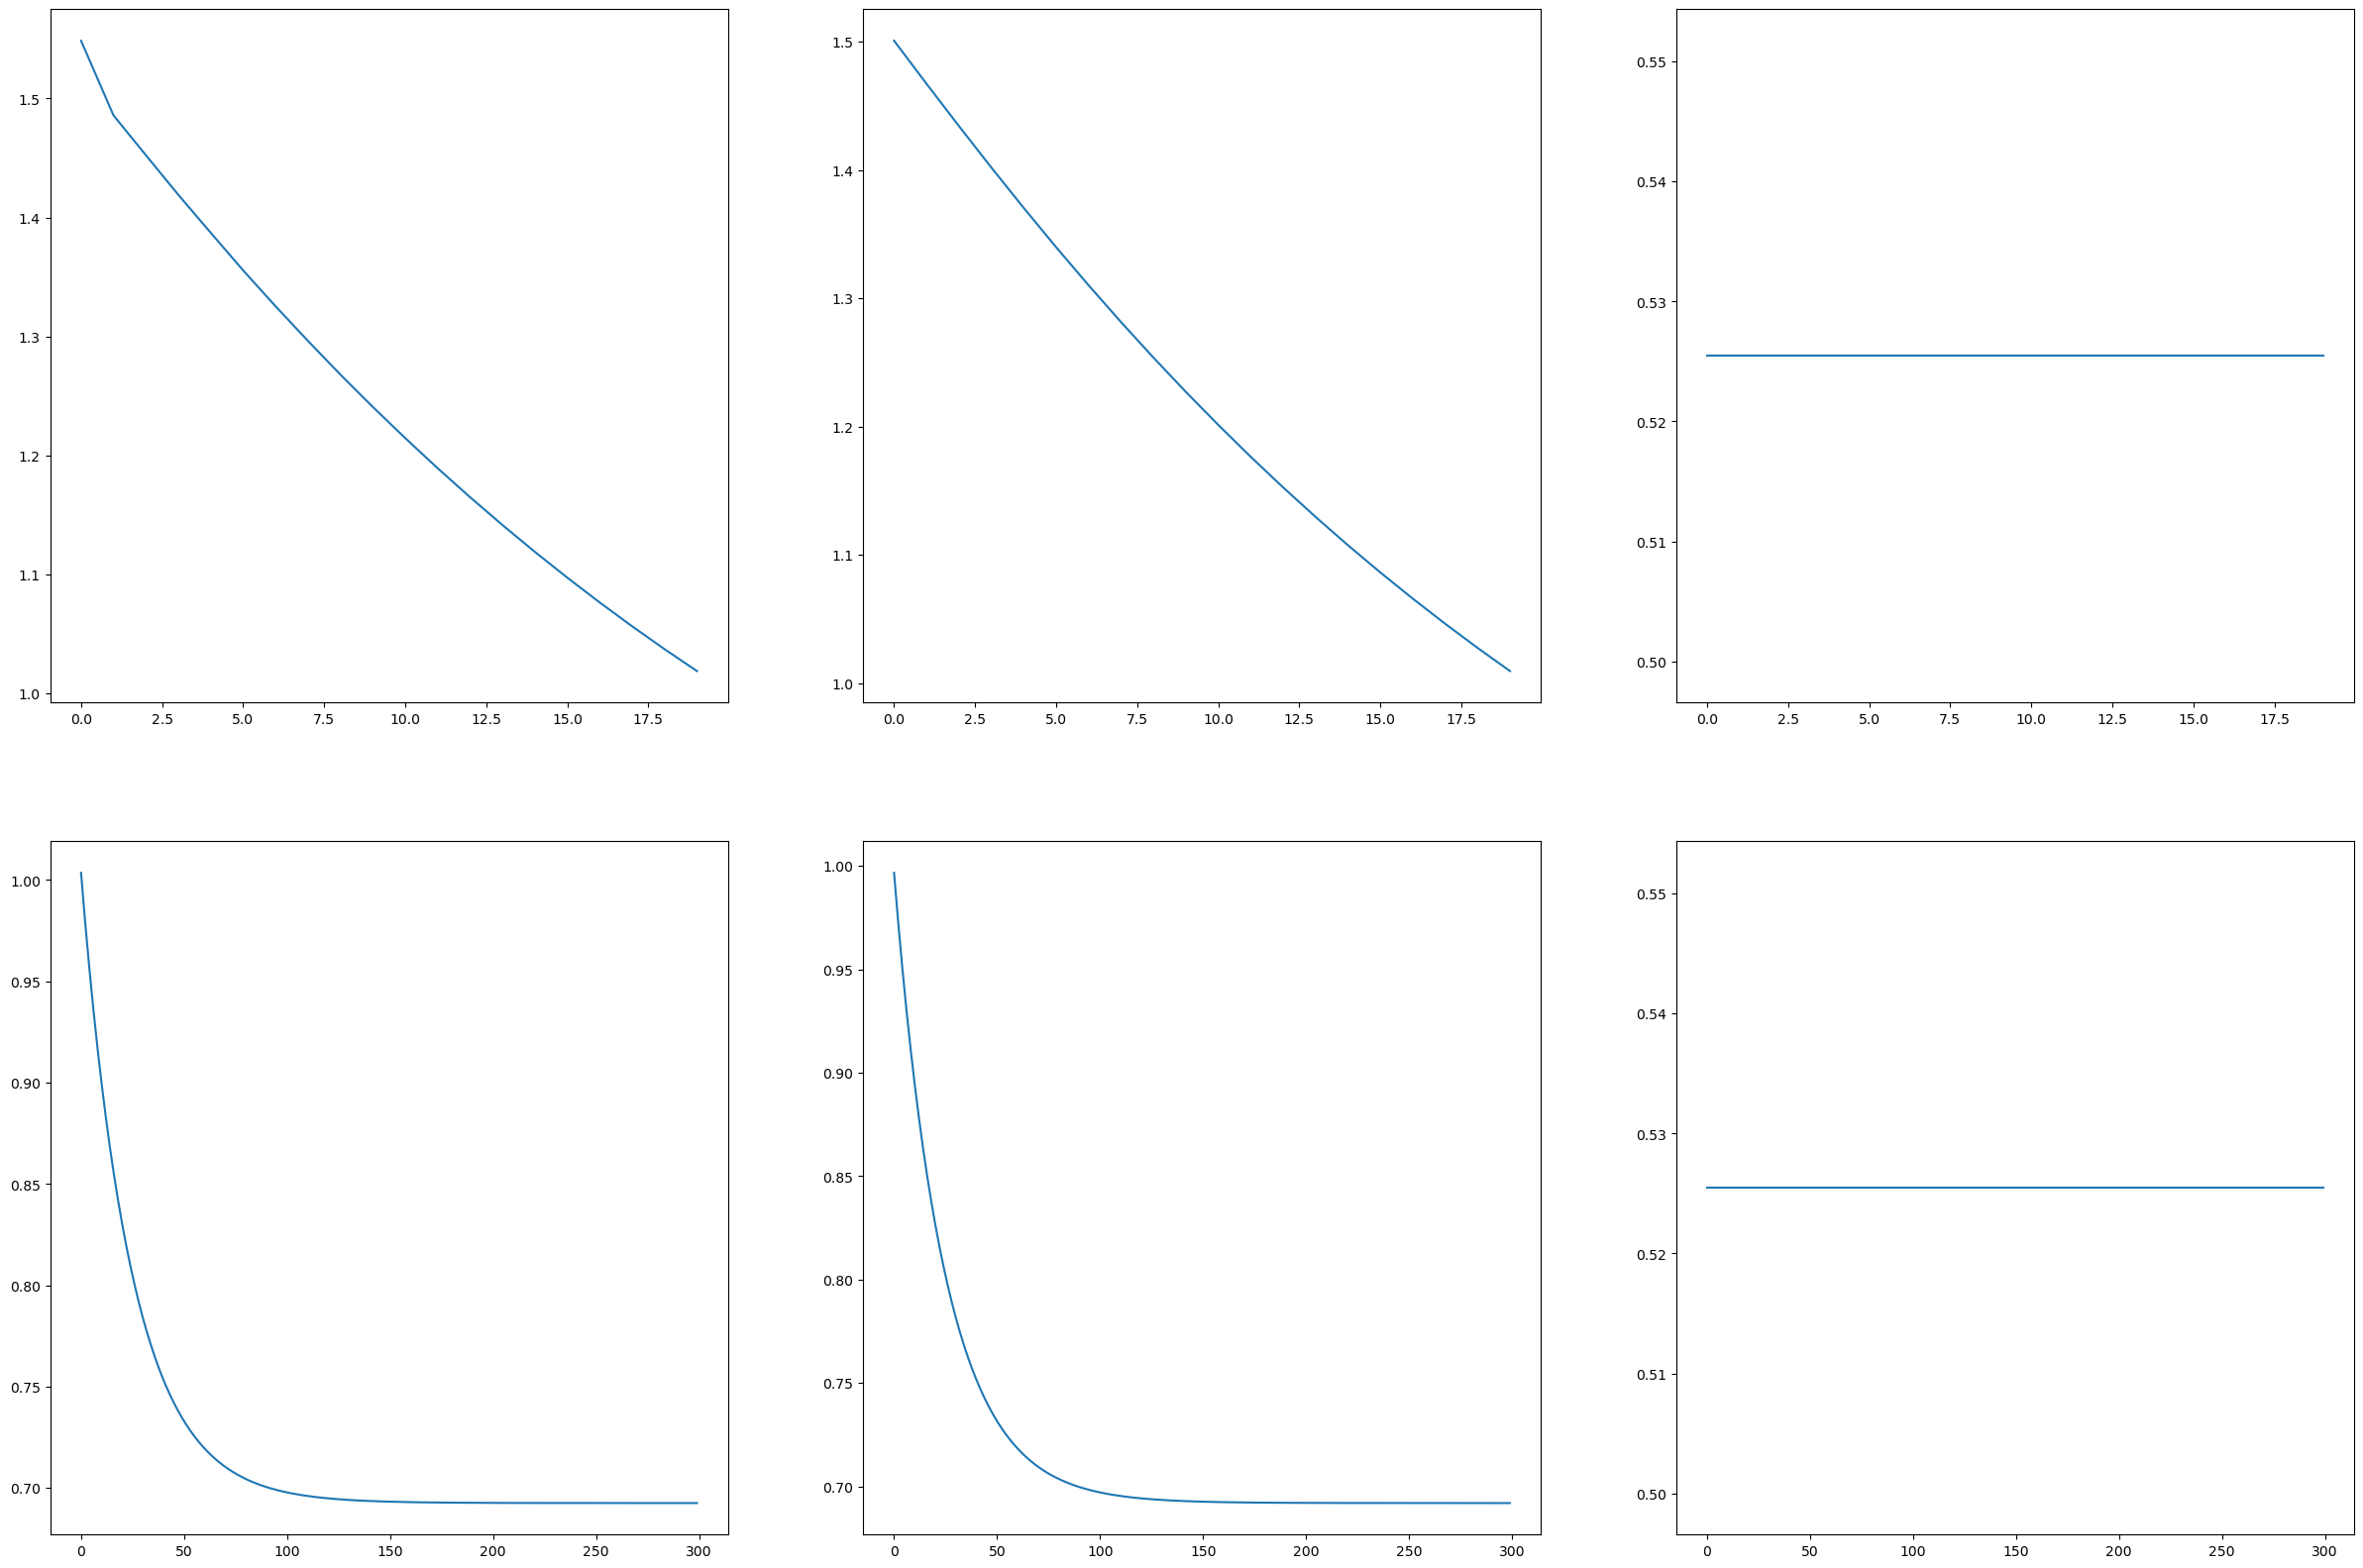

In [18]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(resnet_dense_history['train_loss'])
plt.subplot(232)
plt.plot(resnet_dense_history['val_loss'])
plt.subplot(233)
plt.plot(resnet_dense_history['val_acc'])
plt.subplot(234)
plt.plot(resnet_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(resnet_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(resnet_fine_tune_history['val_acc'])

## Test

In [19]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

21/21 [==============================] - 2s 71ms/step - loss: 0.6984 - categorical_accuracy: 0.4383 - precision_2: 0.0000e+00 - precision_3: 0.4383


# VGG16

In [20]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM/'

In [21]:
optimiser=tf.keras.optimizers.Adam()
losses = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]

In [22]:
model = Model_Training.build_model('vgg16')
model.compile(
    optimizer= optimiser,
    loss=losses,
    metrics=metrics
) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                             

In [23]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM/'
model, vgg16_dense_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0   

2023-02-22 05:59:48.036708: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 05:59:48.036750: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


102/102 [==============================] - 26s 197ms/step - loss: 0.7125 - categorical_accuracy: 0.5288 - precision_2: 0.5148 - precision_3: 0.5373 - val_loss: 0.6921 - val_categorical_accuracy: 0.5278 - val_precision_2: 0.5128 - val_precision_3: 0.5293
Epoch 2/2
102/102 [==============================] - 18s 176ms/step - loss: 0.6951 - categorical_accuracy: 0.5190 - precision_2: 0.5104 - precision_3: 0.5196 - val_loss: 0.6920 - val_categorical_accuracy: 0.5394 - val_precision_2: 0.8000 - val_precision_3: 0.5332
Epoch 3/3
102/102 [==============================] - 18s 176ms/step - loss: 0.6927 - categorical_accuracy: 0.5380 - precision_2: 0.5912 - precision_3: 0.5314 - val_loss: 0.6920 - val_categorical_accuracy: 0.5347 - val_precision_2: 0.6111 - val_precision_3: 0.5314
Epoch 4/4
102/102 [==============================] - 18s 175ms/step - loss: 0.6931 - categorical_accuracy: 0.5196 - precision_2: 0.5556 - precision_3: 0.5190 - val_loss: 0.6922 - val_categorical_accuracy: 0.5324 - val_

## Fine Tune

In [24]:
model, vgg16_fine_tune_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 16,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0   

## Figures

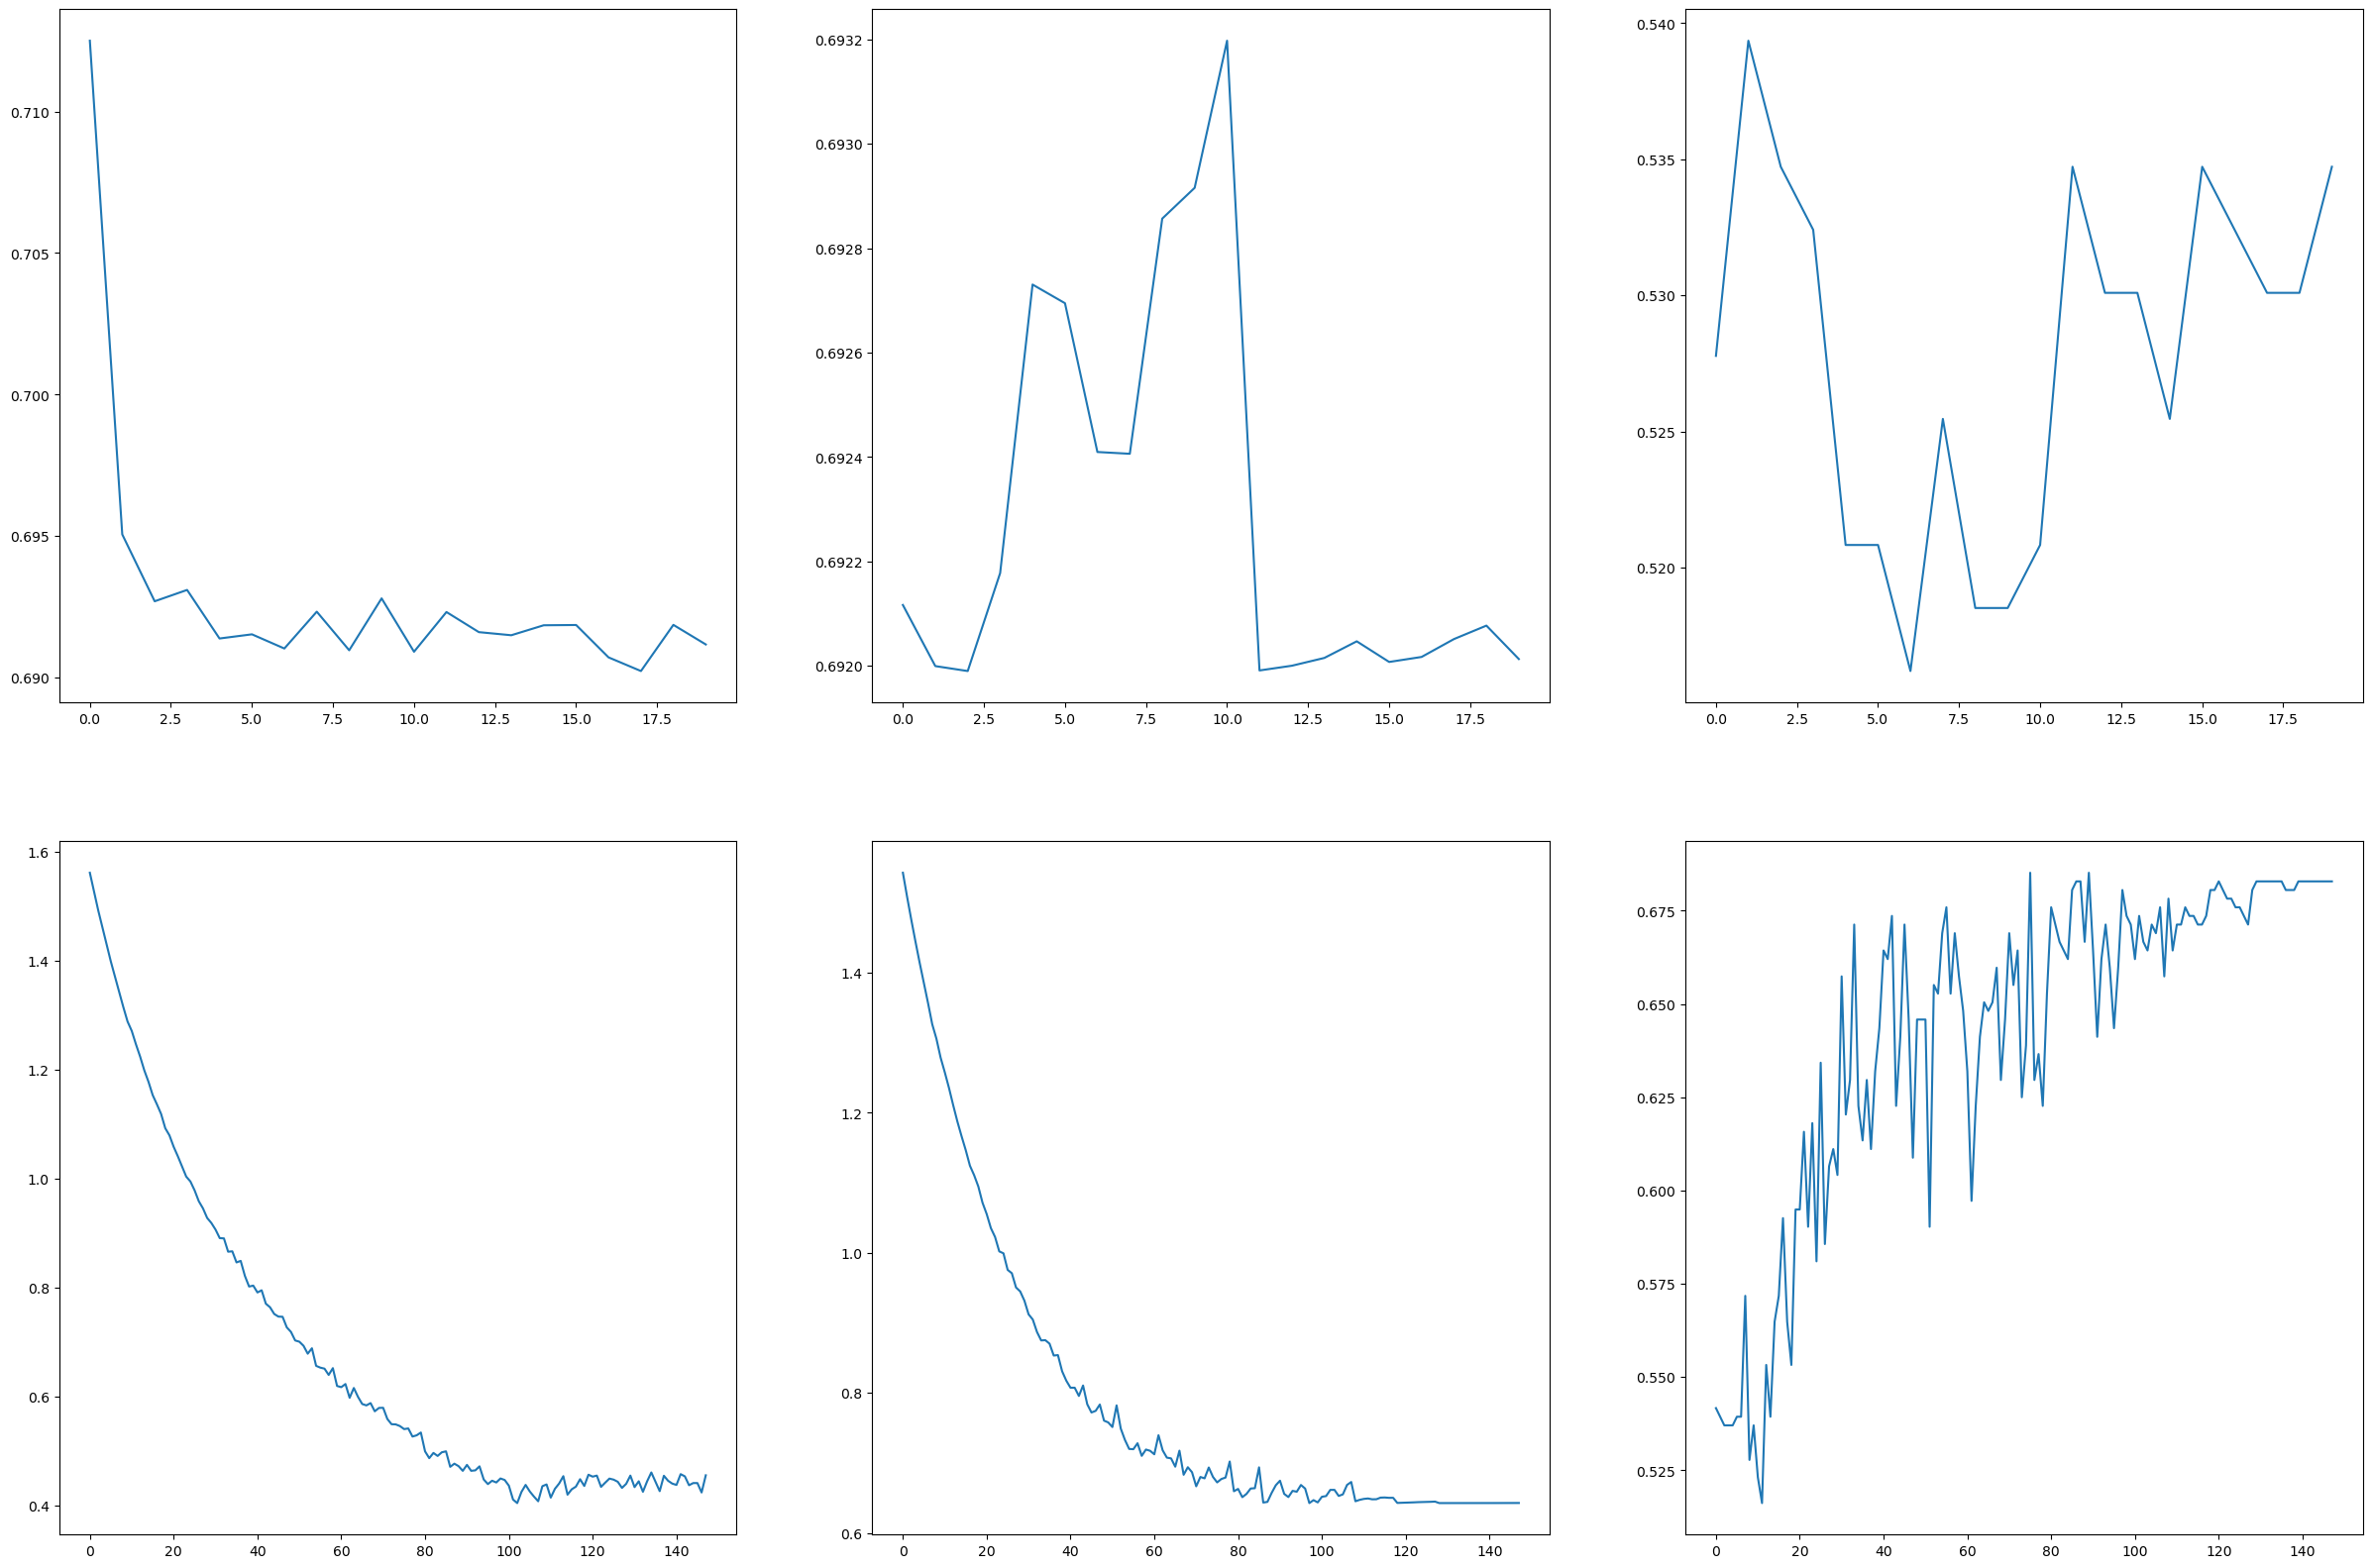

In [25]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(vgg16_dense_history['train_loss'])
plt.subplot(232)
plt.plot(vgg16_dense_history['val_loss'])
plt.subplot(233)
plt.plot(vgg16_dense_history['val_acc'])
plt.subplot(234)
plt.plot(vgg16_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(vgg16_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(vgg16_fine_tune_history['val_acc'])

## Test

In [26]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

21/21 [==============================] - 2s 86ms/step - loss: 0.6662 - categorical_accuracy: 0.6389 - precision_4: 0.7181 - precision_5: 0.5714


# EfficientNet

In [27]:
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM/'
model, effnet_dense_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = False,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.L2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 8)                 1228808   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 8)                 72    

## Fine Tune

In [28]:
model, effnet_fine_tune_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=300,
    patience=30,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten_1 (Flatten)         (None, 153600)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1228808   
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0   

## Figures

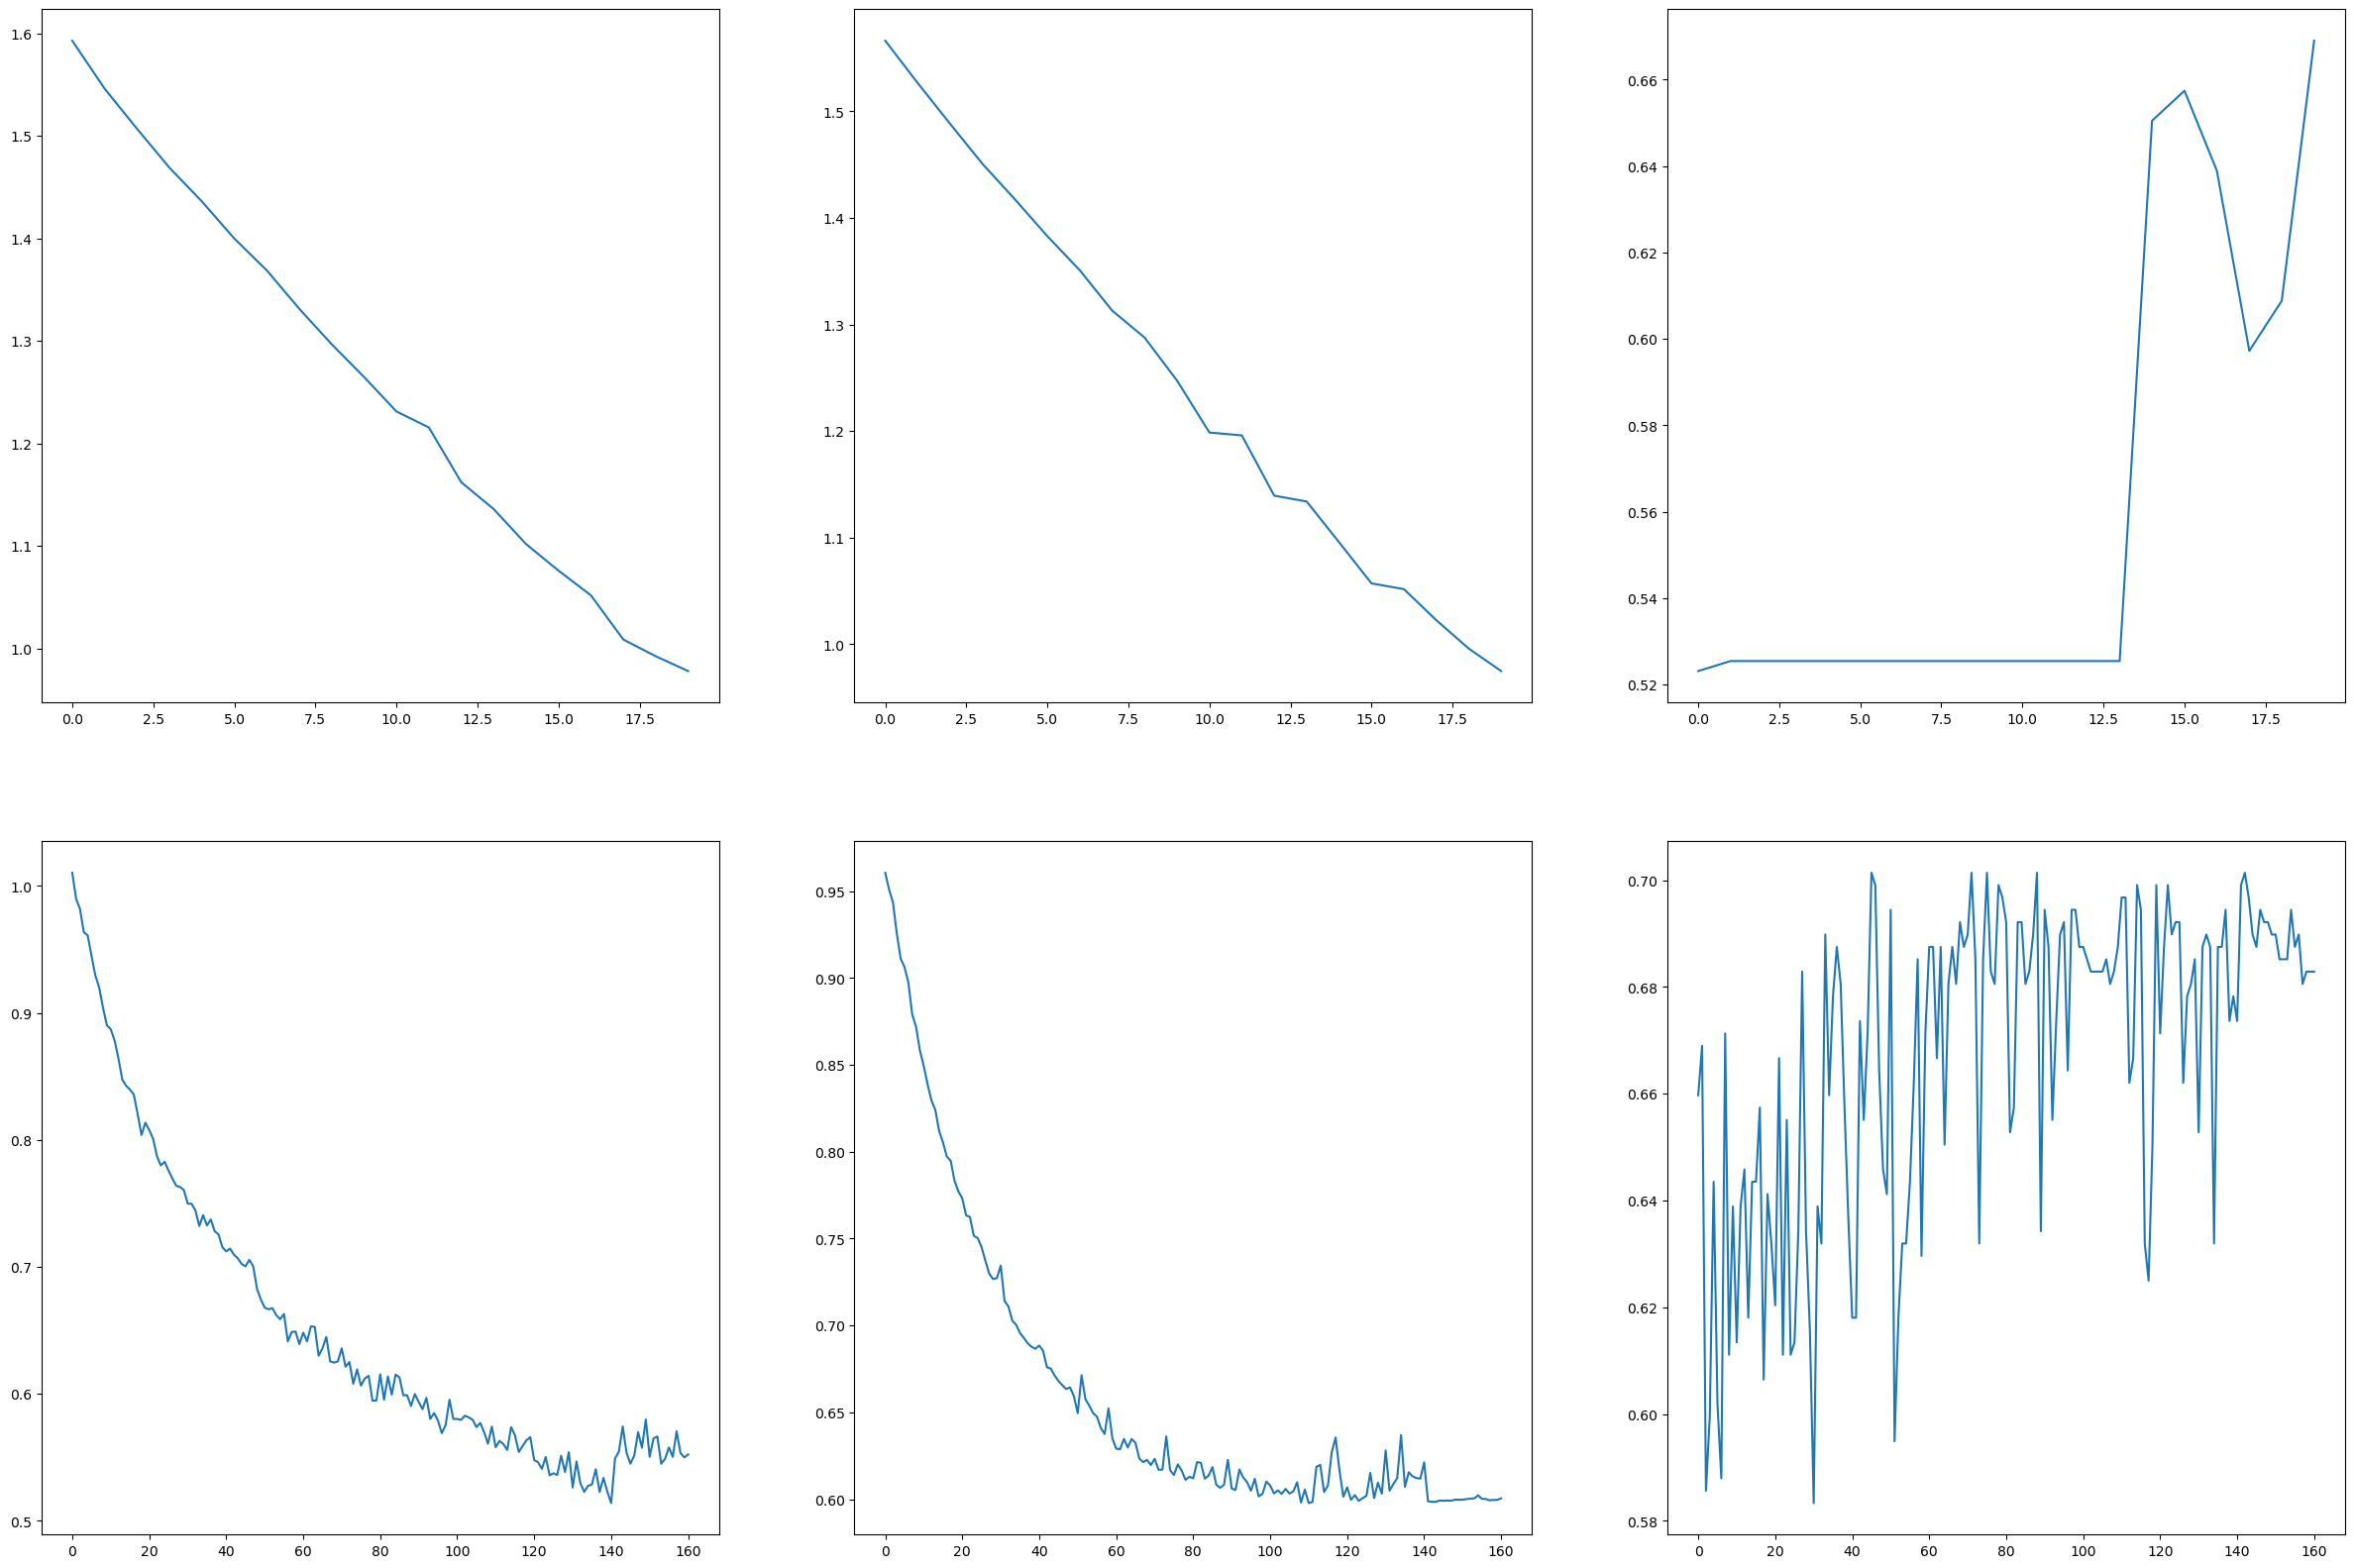

In [29]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(effnet_dense_history['train_loss'])
plt.subplot(232)
plt.plot(effnet_dense_history['val_loss'])
plt.subplot(233)
plt.plot(effnet_dense_history['val_acc'])
plt.subplot(234)
plt.plot(effnet_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(effnet_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(effnet_fine_tune_history['val_acc'])

## Test

In [30]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

21/21 [==============================] - 2s 86ms/step - loss: 0.6136 - categorical_accuracy: 0.6821 - recall_2: 0.6154 - recall_3: 0.7676


# ConvNext

In [31]:
weights = '/home/jj/FYP/Checkpoint/Convnext_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Convnext_CBIS_DDSM/'
model, convnext_dense_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 8)                 663560    
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0     

KeyboardInterrupt: 

## Fine Tune

In [ ]:
model, convnext_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    # Top 25 layers are the stage 3 blocks
    trainable_layers = 25,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 663560    
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0   

## Figures

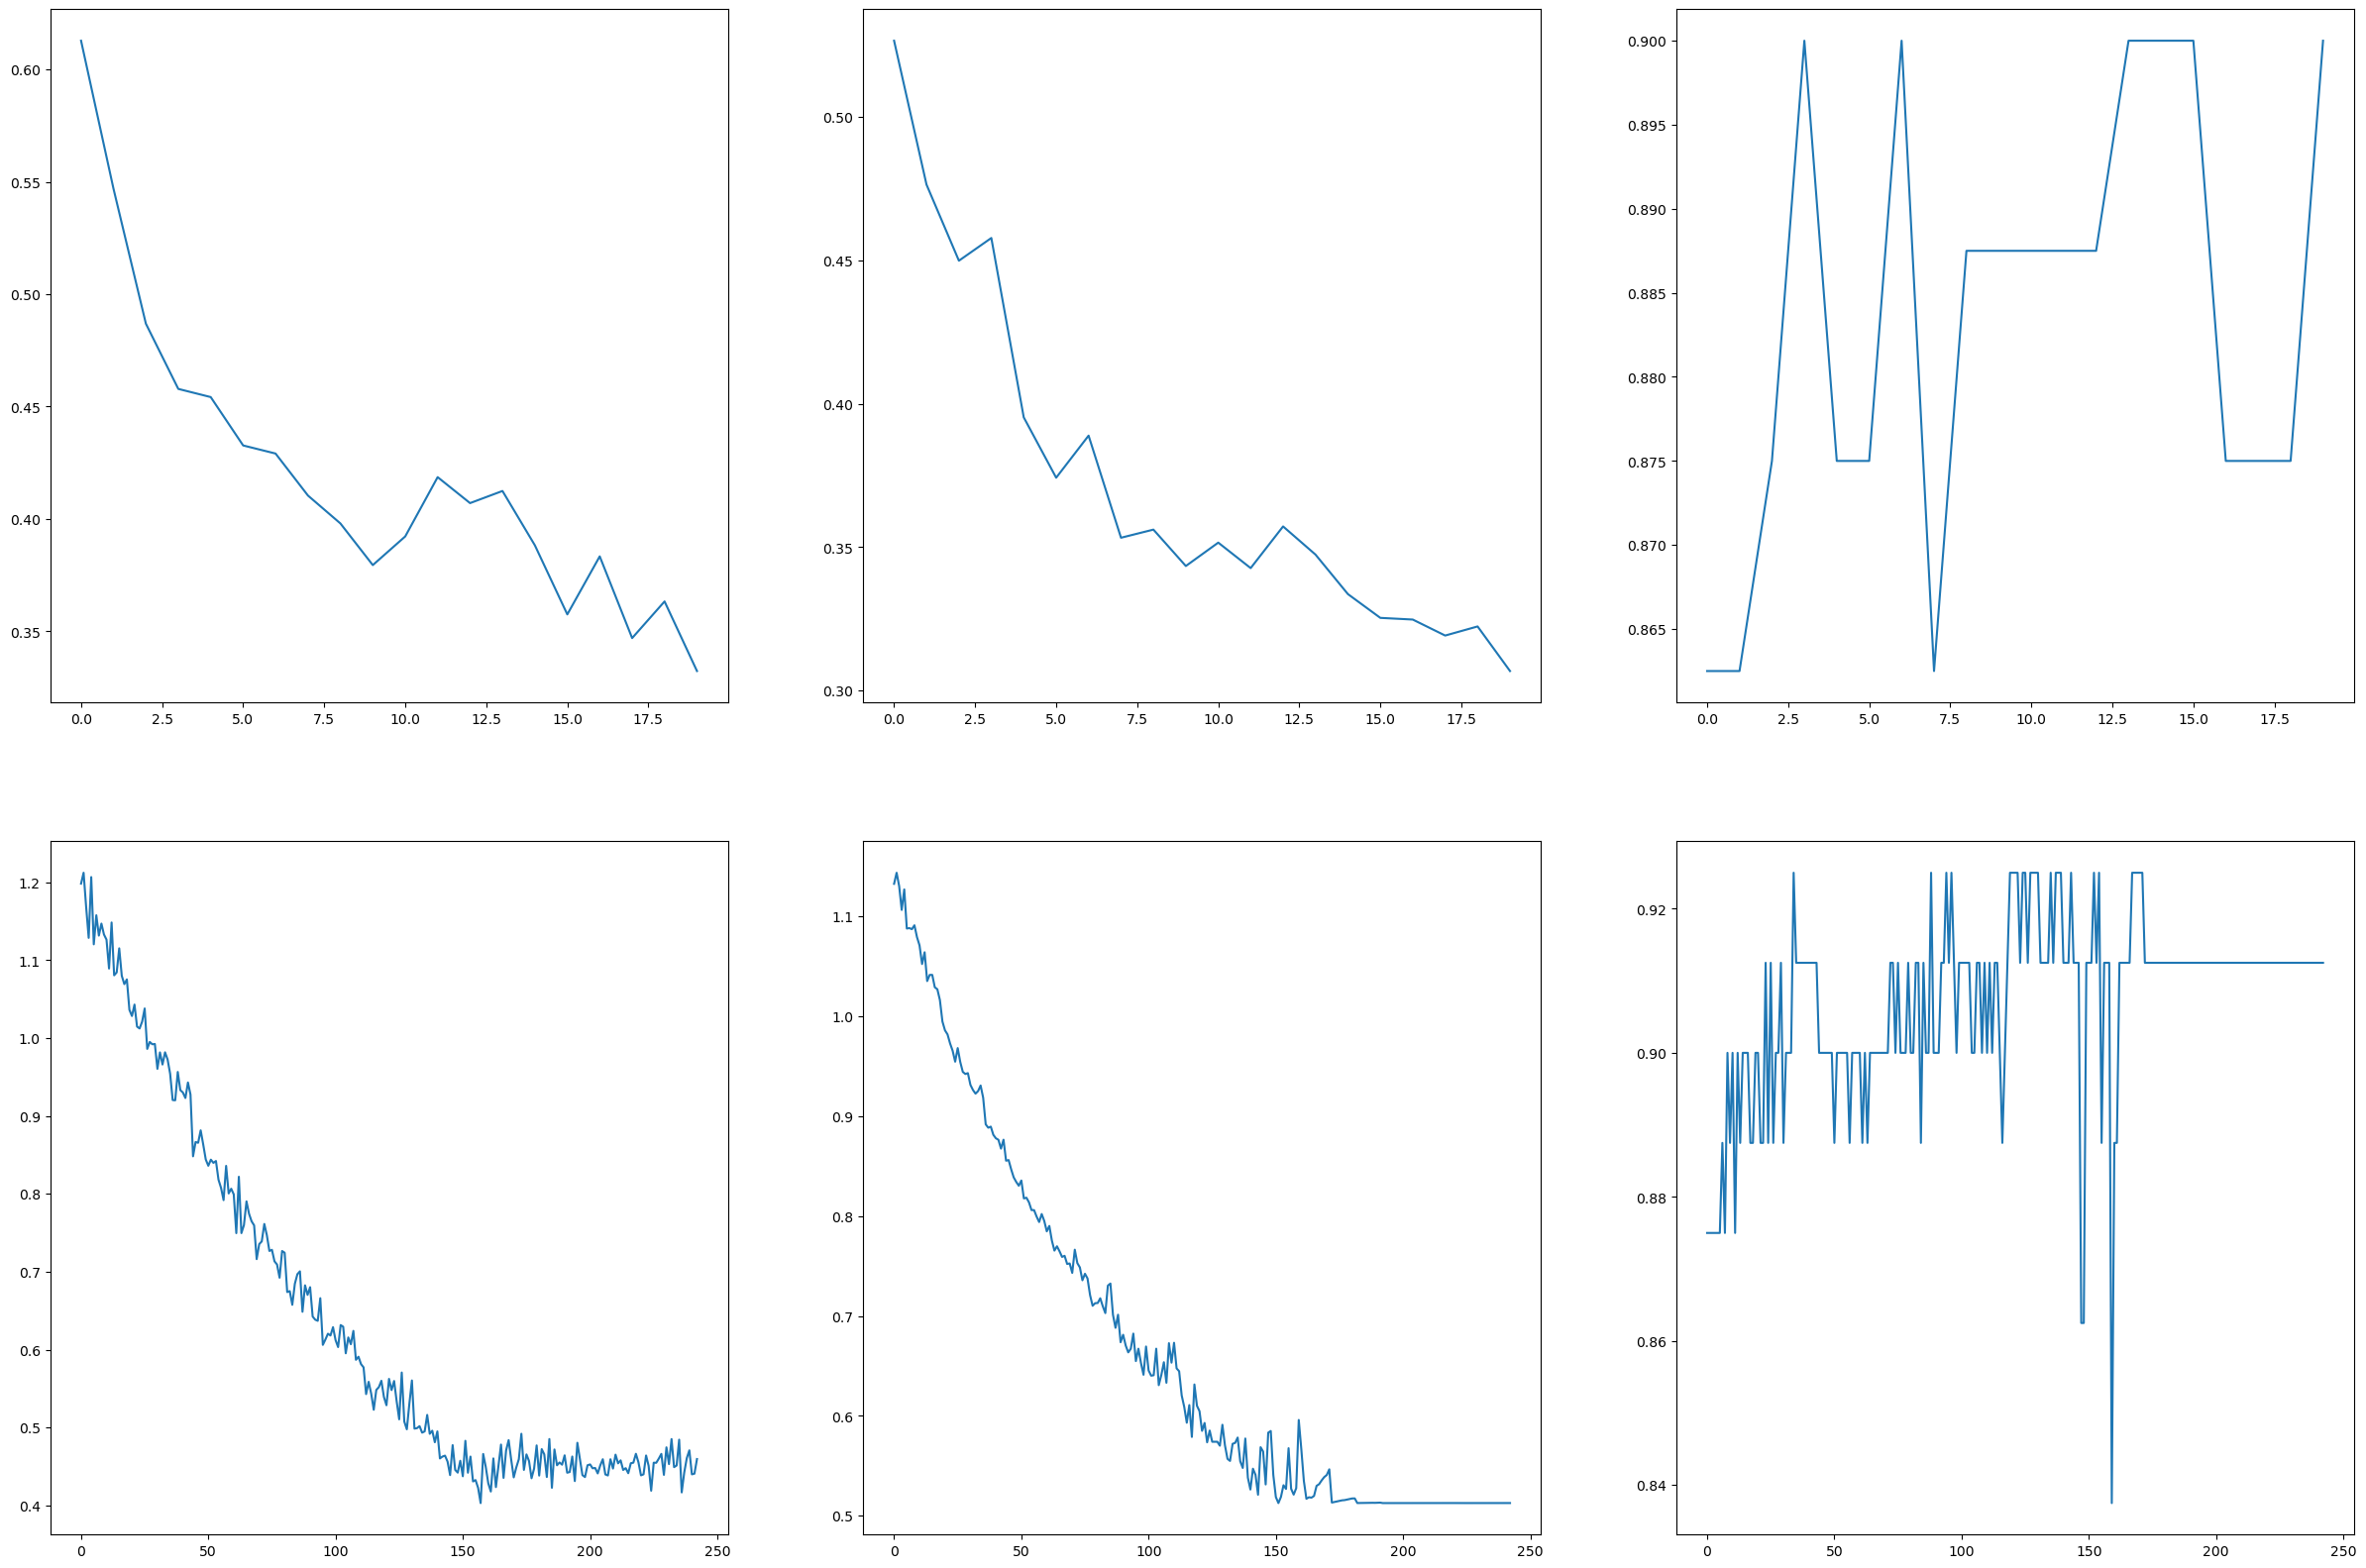

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(convnext_dense_history['train_loss'])
plt.subplot(232)
plt.plot(convnext_dense_history['val_loss'])
plt.subplot(233)
plt.plot(convnext_dense_history['val_acc'])
plt.subplot(234)
plt.plot(convnext_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(convnext_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(convnext_fine_tune_history['val_acc'])

## Test

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 3s 669ms/step - loss: 0.5881 - categorical_accuracy: 0.8472 - precision_2: 0.8421 - precision_3: 0.8667
